# Task 1: Term Deposit Subscription Prediction

## Objective
Predict whether a bank customer will subscribe to a term deposit based on marketing campaign data.

## Dataset
Data of bank customers used to predict if they will subscribe to a term deposit.

In [2]:
import pandas as pd       # For data handling
import numpy as np        # For math
import matplotlib.pyplot as plt   # For basic plots
import seaborn as sns     # For nicer plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

#### Loading and Exploring data

In [3]:
# Load the dataset
data = pd.read_csv("bank-additional-full.csv")

In [4]:
# Peek at first 5 rows
data.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Check column info and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41205 entries, 0 to 41204
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41205 non-null  int64  
 1   age             41205 non-null  int64  
 2   job             41205 non-null  object 
 3   marital         41188 non-null  object 
 4   education       41205 non-null  object 
 5   default         41205 non-null  object 
 6   housing         41205 non-null  object 
 7   loan            41205 non-null  object 
 8   contact         41205 non-null  object 
 9   month           41205 non-null  object 
 10  day_of_week     41205 non-null  object 
 11  duration        41205 non-null  int64  
 12  campaign        41205 non-null  int64  
 13  pdays           41205 non-null  int64  
 14  previous        41205 non-null  int64  
 15  poutcome        41205 non-null  object 
 16  emp.var.rate    41205 non-null  float64
 17  cons.price.idx  41205 non-null 

#### Handling missing Vaules

In [6]:
# Check for missing values
data.isnull().sum()

Unnamed: 0         0
age                0
job                0
marital           17
education          0
default            0
housing            0
loan               0
contact            0
month              0
day_of_week        0
duration           0
campaign           0
pdays              0
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
y                  0
dtype: int64

In [7]:
# Drop unnecessary index column
data = data.drop('Unnamed: 0', axis=1) #axis:1 means drop the column

In [9]:
# Fill missing values in 'marital'
data['marital'] = data['marital'].fillna('unknown')

#### EDA 
EDA helps us see trends, check imbalances, and plan preprocessing.

In [10]:
# Check target distribution
data['y'].value_counts()

y
no     36565
yes     4640
Name: count, dtype: int64

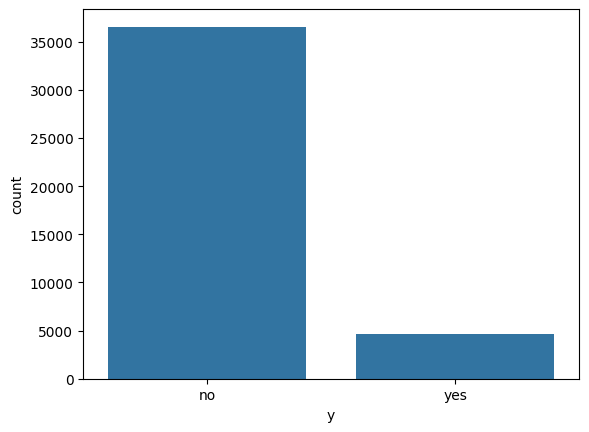

In [11]:
sns.countplot(x='y', data=data)
plt.show()

In [12]:
# Check numeric feature statistics
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000
mean,40.021988,258.260963,2.566946,962.490523,0.172892,0.082429,93.575806,-40.503507,3.621844,5167.061104
std,10.419599,259.228459,2.769625,186.873817,0.494811,1.570864,0.578762,4.627458,1.734304,72.247265
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


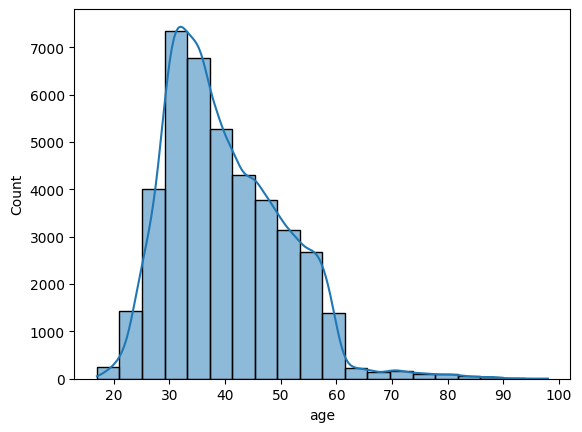

In [13]:
sns.histplot(data['age'], bins=20, kde=True)
plt.show()

In [14]:
data['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2941
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

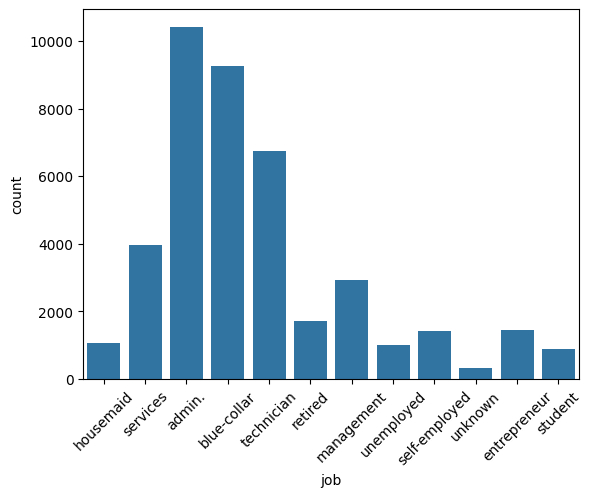